# Analyzing survey data and building discrete choice models

## Imports and reading in data

In [1]:
import os
import re
from collections import OrderedDict

import pandas as pd
import numpy as np

import pylogit as pl

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats.distributions import chi2

import warnings
warnings.filterwarnings("ignore")

In [2]:
# the file in my directory is called 'airbnb-yishen.csv'
airbnb_raw = pd.read_csv(('airbnb-yishen.csv'), sep=',')

## Data cleaning

In [3]:
# these columns are redundant
cols_to_drop = ['Q21?leisure3p3n?',
                'Q18(leisure,1p6n)',
                'Q23(business 0p2n)',
                'Q22(business1p1n)']
airbnb_clean = airbnb_raw.drop(columns=cols_to_drop)
airbnb_clean = airbnb_clean.dropna()
airbnb_clean = airbnb_clean.reset_index().drop(columns='index')

In [4]:
old_names = list(airbnb_clean)[:12]
new_names = ['duration',
            'used_airbnb',
            'travel_freq',
            'tourism_pref',
            'choice_leisure_group',
            'choice_leisure_couple',
            'choice_business_alone',
            'choice_business_couple',
            'gender',
            'employment',
            'age',
            'income']
airbnb_clean = airbnb_clean.rename(columns={old: new for old, new in zip(old_names, new_names)})

In [5]:
# replace income values
airbnb_clean['income'] = airbnb_clean['income'].str.replace('$', '')
airbnb_clean['income'] = airbnb_clean['income'].str.replace(',', '')
airbnb_clean['income'] = airbnb_clean['income'].str.strip()

In [6]:
airbnb_clean.shape

(149, 168)

After removing those records with empty responses we end up with a total of **149 responses** to our Qualtrics survey.

***

## Some analysis on respondents' profile

In [7]:
airbnb_clean['gender'].value_counts()

Male      86
Female    62
Others     1
Name: gender, dtype: int64

In [8]:
airbnb_clean['employment'].value_counts()

Employed      93
Student       50
Unemployed     6
Name: employment, dtype: int64

In [9]:
airbnb_clean['used_airbnb'].value_counts()

Yes    132
No      17
Name: used_airbnb, dtype: int64

In [10]:
airbnb_clean['income'].value_counts()

> 63000           31
20000 -  31000    31
< 14000           29
31000 -  50000    21
50000 -  63000    19
14000 - 20000     18
Name: income, dtype: int64

In [170]:
airbnb_clean["tourism_pref"].value_counts()

Nature                         68
Cultural sightseeing           45
Entertainments / Night life    32
Others                          4
Name: tourism_pref, dtype: int64

In [226]:
airbnb_clean["Property Type"].value_counts()

KeyError: 'Property Type'

(array([ 1.,  0.,  0.,  0.,  0., 78., 46., 13.,  8.,  3.]),
 array([-24. , -15.6,  -7.2,   1.2,   9.6,  18. ,  26.4,  34.8,  43.2,
         51.6,  60. ]),
 <a list of 10 Patch objects>)

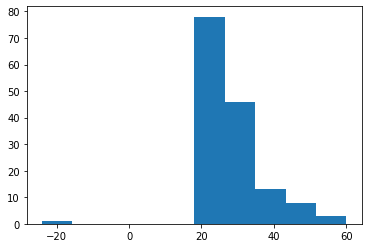

In [11]:
plt.hist(airbnb_clean['age'])

In [12]:
# correction of negative age
airbnb_clean.loc[airbnb_clean['age'] < 0, 'age'] = np.abs(airbnb_clean.loc[airbnb_clean['age'] < 0, 'age'])

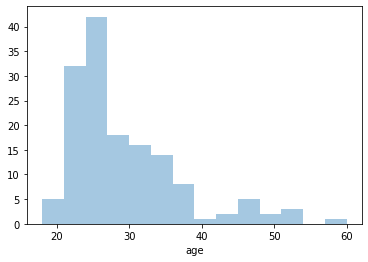

In [13]:
sns.distplot(airbnb_clean['age'], kde=False);

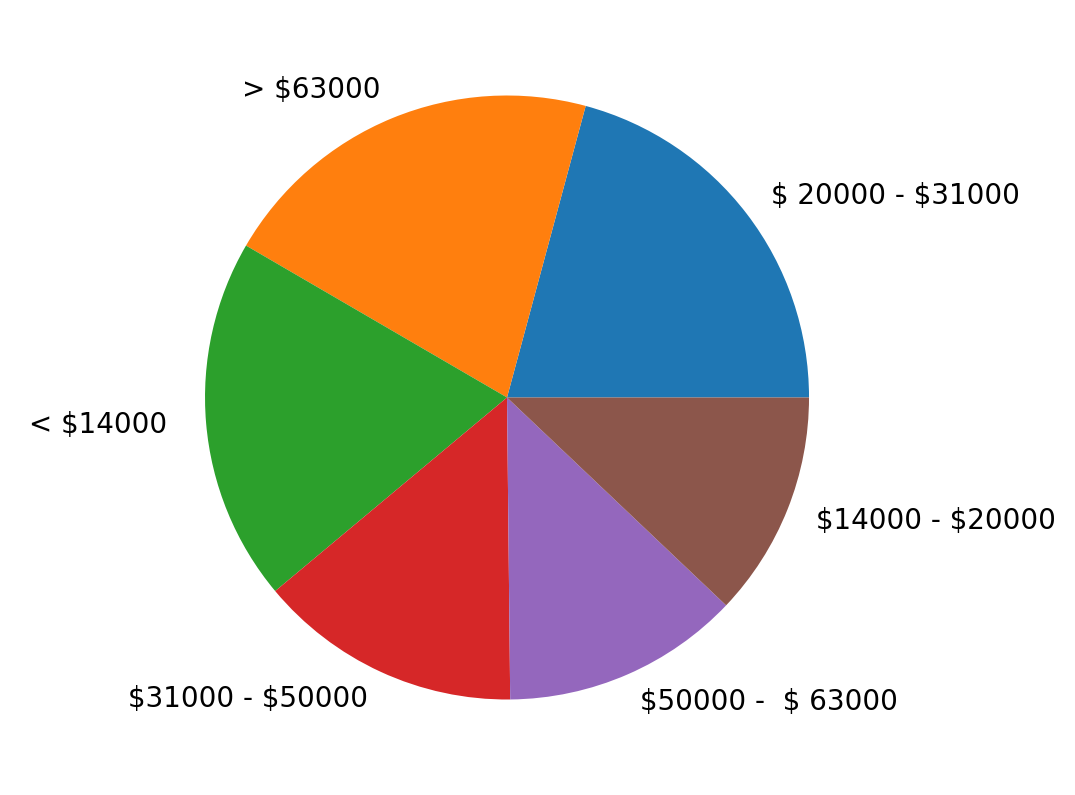

In [14]:
#creatiing histogram of income distribution 
#airbnb_clean['income'].unique()
income_bins = ["$ 20000 - \$31000"  , "> $63000",    
" < $14000 " ,'$31000 - \$50000',
"$50000 -  \$ 63000", "$14000 - \$20000"] 
plt.figure(figsize = (5,5), dpi = 200)
plt.pie(airbnb_clean['income'].value_counts(), labels = income_bins)
plt.savefig("income_pie.png")
plt.show()

***

## Reshape dataset

In [14]:
list(airbnb_clean)

['duration',
 'used_airbnb',
 'travel_freq',
 'tourism_pref',
 'choice_leisure_group',
 'choice_leisure_couple',
 'choice_business_alone',
 'choice_business_couple',
 'gender',
 'employment',
 'age',
 'income',
 'Host Response Time11',
 'Superhost11',
 'Neighbourhood11',
 'Property Type11',
 'Bathroom11',
 'Bedroom11',
 'Beds11',
 'TV11',
 'Pool11',
 'Price11',
 'Deposit11',
 'Cancellation11',
 'Review11',
 'Host Response Time12',
 'Superhost12',
 'Neighbourhood12',
 'Property Type12',
 'Bathroom12',
 'Bedroom12',
 'Beds12',
 'TV12',
 'Pool12',
 'Price12',
 'Deposit12',
 'Cancellation12',
 'Review12',
 'Host Response Time13',
 'Superhost13',
 'Neighbourhood13',
 'Property Type13',
 'Bathroom13',
 'Bedroom13',
 'Beds13',
 'TV13',
 'Pool13',
 'Price13',
 'Deposit13',
 'Cancellation13',
 'Review13',
 'Host Response Time 21',
 'Superhost21',
 'Neighbourhood21',
 'Property Type21',
 'Bathroom21',
 'Bedroom21',
 'Bed21',
 'TV21',
 'Pool21',
 'Price21',
 'Depost21',
 'Cancellation21',
 'Revie

In [15]:
# we consider each of the four scenarios as one response
# airbnb_wide = ...

airbnb_id = airbnb_clean.reset_index().rename(columns={'index': 'id'})

indiv_cols = ['id',
                'duration',
                'used_airbnb',
                'travel_freq',
                'tourism_pref',
                'choice_leisure_group',
                'choice_leisure_couple',
                'choice_business_alone',
                'choice_business_couple',
                'gender',
                'employment',
                'age',
                'income']

individuals = airbnb_id[indiv_cols]

id_cols = ['id',
            'duration',
            'used_airbnb',
            'travel_freq',
            'tourism_pref',
            'gender',
            'employment',
            'age',
            'income']

responses = pd.melt(individuals, id_vars=id_cols, var_name='scenario', value_name='choice')
responses['scenario'] = responses['scenario'].str.replace('choice_', '')

In [16]:
cols_choice_set = ['Host Response Time1',
                    'Superhost1',
                    'Neighbourhood1',
                    'Property Type1',
                    'Bathroom1',
                    'Bedroom1',
                    'Beds1',
                    'TV1',
                    'Pool1',
                    'Price1',
                    'Deposit1',
                    'Cancellation1',
                    'Review1',
                    'Host Response Time2',
                    'Superhost2',
                    'Neighbourhood2',
                    'Property Type2',
                    'Bathroom2',
                    'Bedroom2',
                    'Beds2',
                    'TV2',
                    'Pool2',
                    'Price2',
                    'Deposit2',
                    'Cancellation2',
                    'Review2',
                    'Host Response Time3',
                    'Superhost3',
                    'Neighbourhood3',
                    'Property Type3',
                    'Bathroom3',
                    'Bedroom3',
                    'Beds3',
                    'TV3',
                    'Pool3',
                    'Price3',
                    'Deposit3',
                    'Cancellation3',
                    'Review3']

scenario_1 = airbnb_id.iloc[:, 13:52]
scenario_1.columns = cols_choice_set
scenario_1['scenario'] = 'leisure_group'
scenario_1['id'] = airbnb_id['id']

scenario_2 = airbnb_id.iloc[:, 52:91]
scenario_2.columns = cols_choice_set
scenario_2['scenario'] = 'leisure_couple'
scenario_2['id'] = airbnb_id['id']

scenario_3 = airbnb_id.iloc[:, 91:130]
scenario_3.columns = cols_choice_set
scenario_3['scenario'] = 'business_alone'
scenario_3['id'] = airbnb_id['id']

scenario_4 = airbnb_id.iloc[:, 130:]
scenario_4.columns = cols_choice_set
scenario_4['scenario'] = 'business_couple'
scenario_4['id'] = airbnb_id['id']

scenarios = pd.concat([scenario_1, scenario_2, scenario_3, scenario_4], axis=0).reset_index().drop(columns='index')

In [17]:
airbnb_wide = responses.merge(scenarios, left_on=['id', 'scenario'], right_on=['id', 'scenario'])
airbnb_wide = airbnb_wide.sort_values(['id', 'scenario'], ascending=(True, False))

In [18]:
airbnb_wide

,id,duration,used_airbnb,travel_freq,tourism_pref,gender,employment,age,income,scenario,...,Property Type3,Bathroom3,Bedroom3,Beds3,TV3,Pool3,Price3,Deposit3,Cancellation3,Review3
0,0,30,Yes,2 to 5,Nature,Male,Employed,30,31000 - 50000,leisure_group,...,Condominium,2.0,2,3,yes,no,250,300,strict 14 with grace period,100
149,0,30,Yes,2 to 5,Nature,Male,Employed,30,31000 - 50000,leisure_couple,...,Apartment,1.0,1,1,yes,no,99,400,moderate,100
447,0,30,Yes,2 to 5,Nature,Male,Employed,30,31000 - 50000,business_couple,...,Apartment,2.0,2,3,yes,no,259,0,strict 14 with grace period,89
298,0,30,Yes,2 to 5,Nature,Male,Employed,30,31000 - 50000,business_alone,...,Condominium,1.0,1,1,yes,no,99,0,strict 14 with grace period,100
1,1,34,Yes,2 to 5,Nature,Male,Employed,25,20000 - 31000,leisure_group,...,Apartment,2.0,2,3,yes,no,399,250,strict 14 with grace period,100
150,1,34,Yes,2 to 5,Nature,Male,Employed,25,20000 - 31000,leisure_couple,...,Loft,1.0,1,2,yes,no,140,150,strict 14 with grace period,80
448,1,34,Yes,2 to 5,Nature,Male,Employed,25,20000 - 31000,business_couple,...,House,2.0,2,2,yes,no,150,0,flexible,100
299,1,34,Yes,2 to 5,Nature,Male,Employed,25,20000 - 31000,business_alone,...,House,1.0,1,1,yes,no,160,200,strict 14 with grace period,100
2,2,40,Yes,2 to 5,Entertainments / Night life,Male,Employed,45,31000 - 50000,leisure_group,...,Condominium,1.0,3,3,yes,no,195,500,strict 14 with grace period,96
151,2,40,Yes,2 to 5,Entertainments / Night life,Male,Employed,45,31000 - 50000,leisure_couple,...,Apartment,1.0,1,1,yes,no,179,0,strict 14 with grace period,100


The reshaped and cleaned dataset has a total of **596 observations** (149 respondents $\times$ 4 scenarios).

***

## Convert to long format

In [19]:
# first we change the choice column
airbnb_wide['choice'] = airbnb_wide['choice'].str.replace('Choice ', '')
airbnb_wide['choice'] = airbnb_wide['choice'].astype(int)

In [20]:
# add availability variables for pylogit
airbnb_wide['av_1'] = 1
airbnb_wide['av_2'] = 1
airbnb_wide['av_3'] = 1

# add observation id (one per respondent and scenario)
airbnb_wide['obs_id'] = np.arange(airbnb_wide.shape[0], dtype=int) + 1

In [21]:
#  individual specific variables
ind_variables = airbnb_wide.columns.tolist()[1:10]

# alternative attributes
attributes = ['Host Response Time',
             'Superhost',
             'Neighbourhood',
             'Property Type',
             'Bathroom',
             'Bedroom',
             'Beds',
             'TV',
             'Pool',
             'Price',
             'Deposit',
             'Cancellation',
             'Review']

alt_varying_variables = {}
for attr in attributes:
    alt_varying_variables[attr] = dict([(1, attr + str(1)),
                                        (2, attr + str(2)),
                                        (3, attr + str(3))])

# availability variables
availability_variables = {1: 'av_1',
                          2: 'av_2', 
                          3: 'av_3'}

# alternative id, observation id and choice id
custom_alt_id = 'alt_id'
obs_id_column = 'obs_id'
choice_column = 'choice'

In [22]:
airbnb_long = pl.convert_wide_to_long(airbnb_wide, 
                                        ind_variables, 
                                        alt_varying_variables, 
                                        availability_variables, 
                                        obs_id_column, 
                                        choice_column,
                                        new_alt_id_name=custom_alt_id)

airbnb_long.head(12).T

,0,1,2,3,4,5,6,7,8,9,10,11
obs_id,1,1,1,2,2,2,3,3,3,4,4,4
alt_id,1,2,3,1,2,3,1,2,3,1,2,3
choice,0,1,0,1,0,0,0,1,0,0,0,1
duration,30,30,30,30,30,30,30,30,30,30,30,30
used_airbnb,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes
travel_freq,2 to 5,2 to 5,2 to 5,2 to 5,2 to 5,2 to 5,2 to 5,2 to 5,2 to 5,2 to 5,2 to 5,2 to 5
tourism_pref,Nature,Nature,Nature,Nature,Nature,Nature,Nature,Nature,Nature,Nature,Nature,Nature
gender,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male
employment,Employed,Employed,Employed,Employed,Employed,Employed,Employed,Employed,Employed,Employed,Employed,Employed
age,30,30,30,30,30,30,30,30,30,30,30,30


In [225]:
airbnb_long['Property Type'].value_count()

AttributeError: 'Series' object has no attribute 'value_count'

***

## Models

### Prepare data to estimate models

In [24]:
pd.cut(airbnb_long['age'], bins=5)

0         (26.4, 34.8]
1         (26.4, 34.8]
2         (26.4, 34.8]
3         (26.4, 34.8]
4         (26.4, 34.8]
5         (26.4, 34.8]
6         (26.4, 34.8]
7         (26.4, 34.8]
8         (26.4, 34.8]
9         (26.4, 34.8]
10        (26.4, 34.8]
11        (26.4, 34.8]
12      (17.958, 26.4]
13      (17.958, 26.4]
14      (17.958, 26.4]
15      (17.958, 26.4]
16      (17.958, 26.4]
17      (17.958, 26.4]
18      (17.958, 26.4]
19      (17.958, 26.4]
20      (17.958, 26.4]
21      (17.958, 26.4]
22      (17.958, 26.4]
23      (17.958, 26.4]
24        (43.2, 51.6]
25        (43.2, 51.6]
26        (43.2, 51.6]
27        (43.2, 51.6]
28        (43.2, 51.6]
29        (43.2, 51.6]
             ...      
1758    (17.958, 26.4]
1759    (17.958, 26.4]
1760    (17.958, 26.4]
1761    (17.958, 26.4]
1762    (17.958, 26.4]
1763    (17.958, 26.4]
1764    (17.958, 26.4]
1765    (17.958, 26.4]
1766    (17.958, 26.4]
1767    (17.958, 26.4]
1768    (17.958, 26.4]
1769    (17.958, 26.4]
1770    (17

In [223]:
# we need to reformat categorical variables into numerical variables
# numerical vars: age?, bathroom, bedroom, beds, price, deposit, review
# binary vars: used_airbnb, gender, superhost, tv, pool
# categorical vars: travel_freq, tourism_pref, employment, income, scenario, Host Response Time, Neighbourhood, 
# property type, cancellation

airbnb_long_num = airbnb_long.copy()

# change binary variables into integers
airbnb_long_num['used_airbnb'] = (airbnb_long['used_airbnb'] == 'Yes').astype(int)
airbnb_long_num['gender'] = (airbnb_long['gender'] == 'Male').astype(int)
airbnb_long_num['Superhost'] = (airbnb_long['Superhost'] == 't').astype(int)
airbnb_long_num['TV'] = (airbnb_long['TV'] == 'yes').astype(int)
airbnb_long_num['Pool'] = (airbnb_long['Pool'] == 'yes').astype(int)

# change categorical variables into one-hot encoded variables
# change age into categories or brackets
airbnb_long_num['age_cat'] = pd.cut(airbnb_long['age'], bins=5, labels=False)

# first we change names to something more manageable
travel_freq_levels = {'2 to 5': 2.5,
                        '5 to 10': 7.5,
                        '<=1': 1,
                        '>10': 10}

tourism_levels = {'Nature': 'nature',
                    'Cultural sightseeing': 'cultural',
                    'Entertainments / Night life': 'entertainment',
                    'Others': 'other'}

income_levels = {'< 14000': .7,
                 '14000 - 20000': 1.6,
                 '20000 -  31000': 2.5,
                 '31000 -  50000': 4,
                 '50000 -  63000': 5.6,
                 '> 63000': 7 }

#upper limit to time for response
response_levels = {'within an hour': .01,
                    'within a few hours': .05,
                    'within a day': .24 ,
                    'a few days or more': 1.20}

neigh_levels = {'commercial, funky': 'funky',
                'nightclubs, theaters': 'nightlife',
                'landmarks, modern': 'modern',
                'coast, amusement': 'coast',
                'energetic, nightlife': 'energetic',
                'shopping, luxury': 'shopping',
                'landmarks, historic': 'historic'}
cancel_levels = {'flexible' :3, 'moderate':2, 'strict':1, 'strict 14 with grace period': 1}

airbnb_long_num["Deposit"] = airbnb_long_num["Deposit"]/1000
airbnb_long_num['travel_freq'] = airbnb_long['travel_freq'].replace(travel_freq_levels)
airbnb_long_num['tourism_pref'] = airbnb_long['tourism_pref'].replace(tourism_levels)
airbnb_long_num['income'] = airbnb_long['income'].replace(income_levels)
airbnb_long_num['Host Response Time'] = airbnb_long['Host Response Time'].replace(response_levels)
airbnb_long_num['Neighbourhood'] = airbnb_long['Neighbourhood'].replace(neigh_levels)
airbnb_long_num['Cancellation'] = airbnb_long['Cancellation'].replace(cancel_levels)
airbnb_long_num["neighbourhood * gender"] = airbnb_long_num["Neighbourhood"] * (airbnb_long_num["gender"])
airbnb_long_num["Price/income"] = airbnb_long_num["Price"]/1000* airbnb_long_num['income']
airbnb_long_num["Trip_scene"] = airbnb_long_num["scenario"] + " " + airbnb_long_num["tourism_pref"]
# now we create dummy variables (drop one level always)
airbnb_long_num = pd.get_dummies(airbnb_long_num, columns=['age_cat',
                                                        'tourism_pref',
                                                        'scenario',
                                                         "Neighbourhood",
                                                           "Property Type",
                                                        "neighbourhood * gender"])
#property, employent aren't veri impactful 
#
airbnb_long_num = airbnb_long_num.drop(columns=['age_cat_0',
                                                'tourism_pref_other',
                                                'scenario_business_couple',"Neighbourhood_funky","Property Type_Loft",
                                                'neighbourhood * gender_',
                                                'neighbourhood * gender_coast'])

In [224]:
airbnb_long_num.head().T

,0,1,2,3,4
obs_id,1,1,1,2,2
alt_id,1,2,3,1,2
choice,0,1,0,1,0
duration,30,30,30,30,30
used_airbnb,1,1,1,1,1
travel_freq,2.5,2.5,2.5,2.5,2.5
gender,1,1,1,1,1
employment,Employed,Employed,Employed,Employed,Employed
age,30,30,30,30,30
income,4,4,4,4,4


## Model 1: only alternative attributes

In [27]:
# specifying the utility equations
model_1_specification = OrderedDict()
model_1_names = OrderedDict()

# same parameters across alternatives (no interactions for now)
model_1_specification["Price"] = [[1, 2, 3]]
model_1_names["Price"] = ['Price']

model_1_specification["Superhost"] = [[1, 2, 3]]
model_1_names["Superhost"] = ['Superhost']

model_1_specification["Bathroom"] = [[1, 2, 3]]
model_1_names["Bathroom"] = ['Bathrooms']

model_1_specification["TV"] = [[1, 2, 3]]
model_1_names["TV"] = ['TV']

model_1_specification["Pool"] = [[1, 2, 3]]
model_1_names["Pool"] = ['Pool']

model_1_specification["Deposit"] = [[1, 2, 3]]
model_1_names['Deposit'] = ['Deposit']

model_1_specification["Review"] = [[1, 2, 3]]
model_1_names['Review'] = ['Review']

In [28]:
# Estimate the multinomial logit model (MNL)
model_1 = pl.create_choice_model(data=airbnb_long_num,
                                 alt_id_col=custom_alt_id,
                                 obs_id_col=obs_id_column,
                                 choice_col=choice_column,
                                 specification=model_1_specification,
                                 model_type="MNL",
                                 names=model_1_names)

# Specify the initial values and method for the optimization.
d = 7
model_1.fit_mle(np.zeros(d))

Log-likelihood at zero: -654.7729
Initial Log-likelihood: -654.7729
Estimation Time for Point Estimation: 0.03 seconds.
Final log-likelihood: -644.6349


In [29]:
# Look at the estimation results
model_1.get_statsmodels_summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      choice   No. Observations:                  596
Model:             Multinomial Logit Model   Df Residuals:                      589
Method:                                MLE   Df Model:                            7
Date:                     Tue, 05 May 2020   Pseudo R-squ.:                   0.015
Time:                             15:54:31   Pseudo R-bar-squ.:               0.005
AIC:                             1,303.270   Log-Likelihood:               -644.635
BIC:                             1,334.001   LL-Null:                      -654.773
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Price         -0.0042      0.002     -1.703      0.089      -0.009       0.001
Superhost      0.1054      0.112      0.945      0.344      -0.113       0.324
Bathrooms     -0.0265      0.108     -0.246      0.806      -0.238       0.185
TV            -0.5588      0.174     -3.209      0.001      -0.900      -0.218
Pool          -0.1046      1.226     -0.085      0.932      -2.507       2.298
Deposit       -0.0002   9.52e-05     -1.769      0.077      -0.000    1.82e-05
Review         0.0152      0.011      1.401      0.161      -0.006       0.036
==============================================================================
"""

In [253]:
### Model 2

# specifying the utility equations
model_2_specification = OrderedDict()
model_2_names = OrderedDict()

model_2_specification["Price/income"] = [1, 2, 3]
model_2_names["Price/income"] = ["Price/income - Choice 1", "Price/income - Choice 2", "Price/income - Choice 3"]

model_2_specification["TV"] = [[1, 2, 3]]
model_2_names["TV"] = ['TV']

#cannot be alternative specific 
model_2_specification["Deposit"] = [[1, 2, 3]]
model_2_names['Deposit'] = ['Deposit ($)']

model_2_specification["Review"] = [1, 2, 3]
model_2_names['Review'] = ['Review for choice 1','Review for choice 2', 'Review for choice 3']

model_2_specification["used_airbnb"] =  [[2, 3]]
model_2_names['used_airbnb'] = ['Used airbnb before']

#travel frequency wqsn't significant, pool wasn't significant,most of the poeple have already used airbnb, 
#not benefitted t ouse in the model, but shoes a posotive beta,
#bedroom weren't signifiacnt, bathroom have a negative significance 


model_2_specification['tourism_pref_cultural'] = [[2, 3]]
model_2_names['tourism_pref_cultural'] = ['Tourism preference - cultural']

model_2_specification['tourism_pref_entertainment'] = [[2, 3]]
model_2_names['tourism_pref_entertainment'] = ['Tourism preference - entertainment']

model_2_specification['tourism_pref_nature'] = [[2, 3]]
model_2_names['tourism_pref_nature'] = ['Tourism preference - nature']

model_2_specification["neighbourhood * gender_funky"] = [[1, 2, 3]]
model_2_names["neighbourhood * gender_funky"] = ["Neighbourhood (Funky) if Male"]

model_2_specification["neighbourhood * gender_shopping"] = [[1, 2, 3]]
model_2_names["neighbourhood * gender_shopping"] = ["Neighbourhood (Shopping) if Male"]

model_2_specification['Beds'] = [[1, 2, 3]]
model_2_names['Beds'] = ['Beds']

model_2_specification['age'] = [[2, 3]]
model_2_names['age'] = ['Age']

In [254]:
# Estimate the multinomial logit model (MNL)
model_2 = pl.create_choice_model(data=airbnb_long_num,
                                 alt_id_col=custom_alt_id,
                                 obs_id_col=obs_id_column,
                                 choice_col=choice_column,
                                 specification=model_2_specification,
                                 model_type="MNL",
                                 names=model_2_names)

# Specify the initial values and method for the optimization.
d = 16
model_2.fit_mle(np.zeros(d))

Log-likelihood at zero: -654.7729
Initial Log-likelihood: -654.7729
Estimation Time for Point Estimation: 0.07 seconds.
Final log-likelihood: -623.0030


In [255]:
# Look at the estimation results
model_2.get_statsmodels_summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      choice   No. Observations:                  596
Model:             Multinomial Logit Model   Df Residuals:                      580
Method:                                MLE   Df Model:                           16
Date:                     Tue, 05 May 2020   Pseudo R-squ.:                   0.049
Time:                             22:46:14   Pseudo R-bar-squ.:               0.024
AIC:                             1,278.006   Log-Likelihood:               -623.003
BIC:                             1,348.250   LL-Null:                      -654.773
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Price/income - Choice 1               -1.0983      0.609     -1.803      0.071      -2.293       0.096
Price/income - Choice 2               -0.8093      0.596     -1.358      0.175      -1.978       0.359
Price/income - Choice 3               -0.5419      0.611     -0.887      0.375      -1.739       0.656
TV                                    -0.6404      0.181     -3.543      0.000      -0.995      -0.286
Deposit ($)                           -0.1824      0.096     -1.910      0.056      -0.370       0.005
Review for choice 1                    0.0138      0.012      1.185      0.236      -0.009       0.037
Review for choice 2                    0.0222      0.011      2.087      0.037       0.001       0.043
Review for choice 3                    0.0166      0.011      1.553      0.120      -0.004       0.037
Used airbnb before                     0.2440      0.290      0.841      0.400      -0.325       0.813
Tourism preference - cultural         -1.5055      0.734     -2.052      0.040      -2.943      -0.068
Tourism preference - entertainment    -1.5482      0.738     -2.098      0.036      -2.994      -0.102
Tourism preference - nature           -0.9182      0.726     -1.264      0.206      -2.342       0.505
Neighbourhood (Funky) if Male         -0.2794      0.163     -1.716      0.086      -0.598       0.040
Neighbourhood (Shopping) if Male      -0.6611      0.277     -2.386      0.017      -1.204      -0.118
Beds                                   0.0323      0.057      0.567      0.571      -0.079       0.144
Age                                    0.0137      0.013      1.074      0.283      -0.011       0.039
======================================================================================================
"""

In [244]:
### Model 3


# specifying the utility equations
model_3_specification = OrderedDict()
model_3_names = OrderedDict()

model_3_specification["Price"] = [[1, 2, 3]]
model_3_names["Price"] = ['Price']

model_3_specification["Superhost"] = [[1, 2, 3]]
model_3_names["Superhost"] = ["Superhost"]

model_3_specification["Bathroom"] = [[1, 2, 3]]
model_3_names["Bathroom"] = ['Bathrooms']

model_3_specification["TV"] = [[1, 2, 3]]
model_3_names["TV"] = ['TV']

model_3_specification["Pool"] = [[1, 2, 3]]
model_3_names["Pool"] = ['Pool']

#cannot be alternative specific 
model_3_specification["Deposit"] = [[1, 2, 3]]
model_3_names['Deposit'] = ['Deposit']

model_3_specification["Review"] = [[1, 2, 3]]
model_3_names['Review'] = ['Review']


model_3_specification['Host Response Time'] = [[1, 2, 3]]
model_3_names['Host Response Time'] = ['Host Response Time']


model_3_specification['Cancellation'] = [[1, 2, 3]]
model_3_names['Cancellation'] = ['Cancellation']

model_3_specification['Bathroom'] = [[1, 2, 3]]
model_3_names['Bathroom'] = ['Bathroom']

#beds are more significant 
model_3_specification['Bedroom'] = [[1, 2, 3]]
model_3_names['Bedroom'] = ['Bedroom']

model_3_specification['Beds'] = [[1, 2, 3]]
model_3_names['Beds'] = ['Beds']

model_3_specification['Property Type_Apartment'] = [[1, 2, 3]]
model_3_names['Property Type_Apartment'] = ['Property Type_Apartment']

# model_3_specification['Property Type_House'] = [[1, 2, 3]]
# model_3_names['Property Type_House'] = ['Property Type_House']

model_3_specification['Neighbourhood_coast'] = [[1, 2, 3]]
model_3_names['Neighbourhood_coast'] = ['Neighbourhood_coast']

# model_3_specification['Neighbourhood_energetic'] = [[1, 2, 3]]
# model_3_names['Neighbourhood_energetic'] = ['Neighbourhood_energetic']

In [245]:
# Estimate the multinomial logit model (MNL)
model_3 = pl.create_choice_model(data=airbnb_long_num,
                                 alt_id_col=custom_alt_id,
                                 obs_id_col=obs_id_column,
                                 choice_col=choice_column,
                                 specification=model_3_specification,
                                 model_type="MNL",
                                 names=model_3_names)

# Specify the initial values and method for the optimization.
d = 13
model_3.fit_mle(np.zeros(d))

Log-likelihood at zero: -654.7729
Initial Log-likelihood: -654.7729
Estimation Time for Point Estimation: 0.01 seconds.
Final log-likelihood: -643.2583


In [246]:
# Look at the estimation results
model_3.get_statsmodels_summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      choice   No. Observations:                  596
Model:             Multinomial Logit Model   Df Residuals:                      583
Method:                                MLE   Df Model:                           13
Date:                     Tue, 05 May 2020   Pseudo R-squ.:                   0.018
Time:                             22:28:03   Pseudo R-bar-squ.:              -0.002
AIC:                             1,312.517   Log-Likelihood:               -643.258
BIC:                             1,369.590   LL-Null:                      -654.773
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Price                      -0.0043      0.003     -1.720      0.085      -0.009       0.001
Superhost                   0.0738      0.117      0.629      0.530      -0.156       0.304
Bathroom                   -0.0586      0.121     -0.485      0.628      -0.295       0.178
TV                         -0.5344      0.178     -3.003      0.003      -0.883      -0.186
Pool                       -0.0985      1.230     -0.080      0.936      -2.510       2.313
Deposit                    -0.1682      0.098     -1.719      0.086      -0.360       0.024
Review                      0.0162      0.011      1.444      0.149      -0.006       0.038
Host Response Time         -0.6100      0.785     -0.777      0.437      -2.148       0.928
Cancellation               -0.0235      0.083     -0.285      0.776      -0.186       0.138
Bedroom                    -0.0094      0.184     -0.051      0.959      -0.371       0.352
Beds                        0.0664      0.065      1.026      0.305      -0.060       0.193
Property Type_Apartment    -0.0538      0.102     -0.529      0.597      -0.253       0.146
Neighbourhood_coast         0.0622      0.140      0.444      0.657      -0.212       0.337
===========================================================================================
"""